In [1]:
import pandas as pd
import re
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset

In [99]:
device = "mps"

# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

tokenizer.add_special_tokens({'pad_token': '<|pad|>'})

# Load the pre-trained model
model = GPT2LMHeadModel.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))  
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

/opt/anaconda3/envs/maui/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

In [100]:
# Cleaning functions
def clean_whitespace(text):
    return " ".join(text.split())

def clean_punctuation(text):
    text = re.sub(r"\s+([?.!,])", r"\1", text)  
    text = re.sub(r"([?.!,])(?=\S)", r"\1 ", text) 
    return text.strip()

def remove_special_characters(text):
    return re.sub(r"[^a-zA-Z0-9\s,.!?]", "", text)

def normalize_case(text):
    return text.lower()

def add_eos_token(text):
    return text + tokenizer.eos_token

def remove_links(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

def clean_joke(joke):
    joke = remove_links(joke)          # Remove links
    joke = clean_whitespace(joke)      # Clean up whitespace
    joke = clean_punctuation(joke)     # Adjust punctuation
    joke = remove_special_characters(joke)  # Remove special characters
    joke = normalize_case(joke)        # Normalize case
    joke = add_eos_token(joke)         # Add EOS token
    joke = clean_whitespace(joke)      # Clean up whitespace
    return joke

# Load and clean your dataset using pandas
df = pd.read_csv('data_/data.csv')
df['Joke'] = df['Joke'].apply(clean_joke)

# Convert the DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

In [101]:
import matplotlib.pyplot as plt
from transformers import TrainerCallback, TrainerState, TrainerControl

class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []

    def on_log(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        if "loss" in state.log_history[-1]:
            self.train_loss.append((state.global_step, state.log_history[-1]["loss"]))
        if "eval_loss" in state.log_history[-1]:
            self.eval_loss.append((state.global_step, state.log_history[-1]["eval_loss"]))

loss_logger = LossLoggerCallback()


In [102]:


# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['Joke'],
        truncation=True,
        padding=True,
        max_length=50,
    )

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['ID', 'Joke'])

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  
)

model.config.resid_pdrop = 0.4
model.config.embd_pdrop = 0.4

# Define simplified training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-jokes-finetuned",
    overwrite_output_dir=True, 
    num_train_epochs=15,                 
    per_device_train_batch_size=8,        
    learning_rate=1e-4,                   
    logging_steps=100,                    
    save_steps=1000,                      
    save_total_limit=1,                   
    weight_decay=0.05, 
    max_grad_norm= 1.0,
    #warmup_steps=500


)

# model.config.resid_pdrop = 0.4
# model.config.embd_pdrop = 0.4

# # Define simplified training arguments
# training_args = TrainingArguments(
#     output_dir="./gpt2-jokes-finetuned",
#     overwrite_output_dir=True, 
#     num_train_epochs=10,                 
#     per_device_train_batch_size=16,        
#     learning_rate=1e-4,                   
#     logging_steps=100,                    
#     save_steps=1000,                      
#     save_total_limit=1,                   
#     weight_decay=0.15, 
#     max_grad_norm= .5,
#     warmup_steps=500


# )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

trainer.add_callback(loss_logger)

trainer.train()

Map:   0%|          | 0/1622 [00:00<?, ? examples/s]

  0%|          | 0/3045 [00:00<?, ?it/s]

{'loss': 6.1524, 'grad_norm': 7.144935607910156, 'learning_rate': 9.671592775041052e-05, 'epoch': 0.49}
{'loss': 3.8511, 'grad_norm': 6.063092231750488, 'learning_rate': 9.343185550082102e-05, 'epoch': 0.99}
{'loss': 3.1287, 'grad_norm': 5.387673854827881, 'learning_rate': 9.014778325123154e-05, 'epoch': 1.48}
{'loss': 3.0612, 'grad_norm': 6.0859761238098145, 'learning_rate': 8.686371100164204e-05, 'epoch': 1.97}
{'loss': 2.5201, 'grad_norm': 7.414225101470947, 'learning_rate': 8.357963875205255e-05, 'epoch': 2.46}
{'loss': 2.4858, 'grad_norm': 6.12352991104126, 'learning_rate': 8.029556650246307e-05, 'epoch': 2.96}
{'loss': 2.0229, 'grad_norm': 8.128273963928223, 'learning_rate': 7.701149425287356e-05, 'epoch': 3.45}
{'loss': 1.9963, 'grad_norm': 6.570198059082031, 'learning_rate': 7.372742200328408e-05, 'epoch': 3.94}
{'loss': 1.5895, 'grad_norm': 8.832693099975586, 'learning_rate': 7.044334975369458e-05, 'epoch': 4.43}
{'loss': 1.6026, 'grad_norm': 7.101964473724365, 'learning_rate'

TrainOutput(global_step=3045, training_loss=1.4178308953596845, metrics={'train_runtime': 609.1309, 'train_samples_per_second': 39.942, 'train_steps_per_second': 4.999, 'total_flos': 620823744000000.0, 'train_loss': 1.4178308953596845, 'epoch': 15.0})

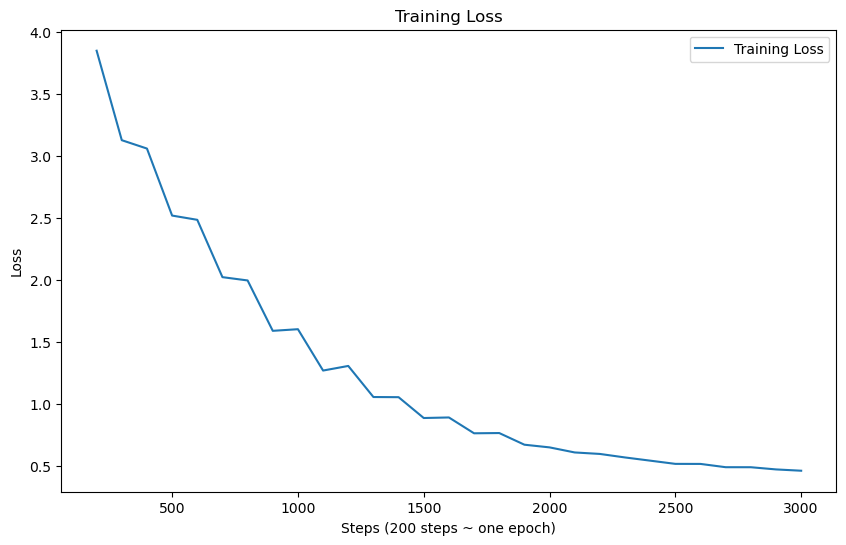

In [103]:
train_steps, train_losses = zip(*loss_logger.train_loss)

plt.figure(figsize=(10, 6))
plt.plot(train_steps[1:], train_losses[1:], label='Training Loss')
plt.xlabel('Steps (200 steps ~ one epoch)')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [111]:
def generate_joke(prompt, max_length=50, num_return_sequences=3):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    
    outputs = model.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        eos_token_id=tokenizer.eos_token_id,   
        pad_token_id=tokenizer.pad_token_id, 
        do_sample=True,
        top_k=50,
        top_p=.8,
        temperature= 1.2,
    )

    # Decode and return the generated joke
    jokes = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return jokes


prompts = ["What did the", "What do you", "Why did the", "When i was"]

for prompt in prompts:
    jokes = generate_joke(prompt)
    print(f'\nJokes starting with {prompt}:')
    for joke in jokes:
        print(joke)


Jokes starting with What did the:
What did the mom say when her baby steps outside her house? i think he wants a bath!
What did the french butter say when it got cold? beurre... i can make anything rome
What did the rabbit say to the rabbit hunter? quack, quack, quack. 

Jokes starting with What do you:
What do you call a fish with no eyes? a fsh
What do you get when you drop a piano in the middle of the road? a flat minor.
What do you get when you cross kazakhstani with a broad brush? a broad brush

Jokes starting with Why did the:
Why did the rope beech beech tree? because its a bit unwieldy to put up.
Why did the grocery delivery guy get fired? he drove people bananas!
Why did the bullet stay home? because he got a job helping to save the town from destruction.

Jokes starting with When i was:
When i was told that by a smart white supremacist, this was the first time i heard that term... well, i muttered.
When i was little, my grandpa wanted to see her married. she wanted to go to 